# File Header

**File Author**: Emily Fletcher

**Student Number**: 18410839

**File Purpose**: Passing a set of images into a Data Set, Aim is to train a model  
              on recognition of the 5 people sampled.

**Last Changed**: 16/05/2023

**Last Model Download**: 16/05/2023

**Version**: 2.0

**Instructions**

Ensure model is corrected to Google Drive with correct directories before proceeding through Stage 2 Onwards

In [54]:
# Key Imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from google.colab import drive
import os, shutil

from tensorflow.keras.utils import image_dataset_from_directory

import numpy as np
import matplotlib.pyplot as plt


# Stage 1: Connecting to the Google Drive

In [46]:
# Force Remount to account for Google Drive Reload Errors
drive.mount('/content/drive', force_remount=True)

#Checking Path is valid 
print(os.path.exists('/content/drive/MyDrive/DataSetAIAssignment/training'))
print(os.path.exists('/content/drive/MyDrive/DataSetAIAssignment/test'))
print(os.path.exists('/content/drive/MyDrive/DataSetAIAssignment/validation'))

Mounted at /content/drive
True
True
True


In [49]:
# Main File Path
base_dir = '/content/drive/MyDrive/DataSetAIAssignment/'

# Setting Parent Folders
train_dir = os.path.join(base_dir, 'training')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Setting Train Folders For Users
train_CB_dir = os.path.join(train_dir, 'CB') # CB
train_EF_dir = os.path.join(train_dir, 'EF') # EF
train_JS_dir = os.path.join(train_dir, 'JS') # JS
train_MB_dir = os.path.join(train_dir, 'MB') # MB
train_RK_dir = os.path.join(train_dir, 'RK') # RK

# Setting Validation Folders For Users
validation_CB_dir = os.path.join(validation_dir, 'CB') # CB
validation_EF_dir = os.path.join(validation_dir, 'EF') # EF
validation_JS_dir = os.path.join(validation_dir, 'JS') # JS
validation_MB_dir = os.path.join(validation_dir, 'MB') # MB
validation_RK_dir = os.path.join(validation_dir, 'RK') # RK

# Setting Test Folders For Users
test_CB_dir = os.path.join(test_dir, 'CB') # CB
test_EF_dir = os.path.join(test_dir, 'EF') # EF
test_JS_dir = os.path.join(test_dir, 'JS') # JS
test_MB_dir = os.path.join(test_dir, 'MB') # MB
test_RK_dir = os.path.join(test_dir, 'RK') # RK


# Section 2: First Pass Of Iterations

*   Assigning Batch Size
*   Setting Image Size
*   Creating VGG16 Base






In [51]:
# Assigning Batches and Image Sizes 
# Image Sizes Allow For Size Consistency

# Training Batches
train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=(180, 180),
    batch_size=32)

# Validation Batches
validation_dataset = image_dataset_from_directory(
    validation_dir,
    image_size=(180, 180),
    batch_size=32)

# Testing Batches
test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(180, 180),
    batch_size=32)


Found 391 files belonging to 5 classes.
Found 49 files belonging to 5 classes.
Found 49 files belonging to 5 classes.


In [55]:
# Creating of the VGG16 Pre-Trained Neural Network

# Weights State The Image Set That Should Be Used
# input_shape should match image size and type used in batches
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3),
    pooling=None
)
# Prints A Summary For The User, Allows Model Checks 
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [56]:
# Assigning labels 
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

#Applying All Labels And Features To Each DataSet
train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 34ms/step


In [57]:
# Applying Layers to the Model
# Helps to Prevent OverFitting
# Can Fine Tune By Adjusting Layers

inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dropout(0.2)(x)    

outputs = layers.Dense(5, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])


learning_rate = 0.001  # Change this value to your desired learning rate
optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)


# Define the EarlyStopping callback
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=5,           # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore the weights of the best epoch
)

# Fitting the Features And Labels From the VGG16 Model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction.keras",
        save_best_only=True,
        monitor="val_loss"),
    early_stopping  # Add the early stopping callback
]

# Can Adjust epochs To Refine Model
# 20 Chosen as visualisation graph levels out at around pass 15
history = model.fit(
    train_features, train_labels,
    epochs=30,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/30
13/13 [==============================] - 1s 27ms/step - loss: 12.9705 - accuracy: 0.7263 - val_loss: 7.8521 - val_accuracy: 0.9184
Epoch 2/30
13/13 [==============================] - 0s 13ms/step - loss: 6.5268 - accuracy: 0.9668 - val_loss: 7.2762 - val_accuracy: 0.8776
Epoch 3/30
13/13 [==============================] - 0s 13ms/step - loss: 5.7596 - accuracy: 0.9770 - val_loss: 7.1328 - val_accuracy: 0.8980
Epoch 4/30
13/13 [==============================] - 0s 13ms/step - loss: 4.9219 - accuracy: 0.9974 - val_loss: 6.8649 - val_accuracy: 0.8980
Epoch 5/30
13/13 [==============================] - 0s 7ms/step - loss: 4.3866 - accuracy: 0.9923 - val_loss: 7.7955 - val_accuracy: 0.8776
Epoch 6/30
13/13 [==============================] - 0s 16ms/step - loss: 3.5754 - accuracy: 0.9949 - val_loss: 4.8871 - val_accuracy: 0.8776
Epoch 7/30
13/13 [==============================] - 0s 20ms/step - loss: 2.9989 - accuracy: 0.9872 - val_loss: 4.7686 - val_accuracy: 0.8776
Epoch 8/30
13

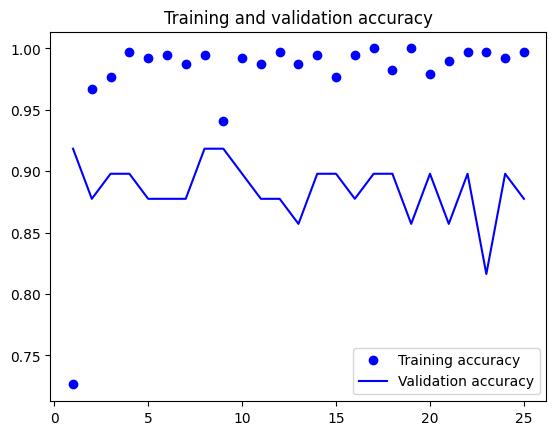

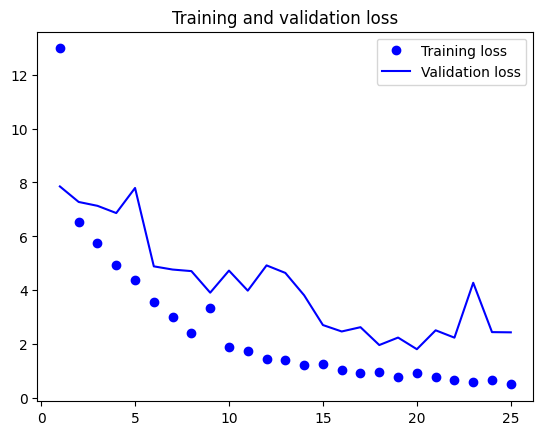

In [58]:
# Generating Visualisation of the Passes
# Allows assessment of training 

# Poor accuracy or high loss could indicate a need to adjust the layers, parameters or review the data samples
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

# Section 3: Further Refinement and Second Set of Iterations

*   Freezing the Base VGG16 Model
*   Adding Image Transformation (Augmentation)



In [59]:
# Re-initialising the VGG16 Model 
# This time bases are frozen, prevents overwriting of previous work

conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

In [60]:
# THis shows to the author the effect of the freezing 
# If values are the same then the model has not be frozen and should be reviewed before continuing
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26
This is the number of trainable weights after freezing the conv base: 0


In [61]:
# Applying image transformations 

# Allows to artifically grow the dataset
# Applying image transformations 
# Allows to artifically grow the dataset
# Can adjust results by changing types of transformations and parameters
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

# Adding layers
# Can add more layers if needed to fine tune
# Same as previous method
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dropout(0.5)(x) 
outputs = layers.Dense(5, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])




In [62]:
# Prints a model summary, allows for user to check accuracy 
model.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 180, 180, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 180, 180, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_18 (Flatten)        (None, 12800)             0  

In [65]:
# Fitting the Features And Labels From the VGG16 Model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss"
    ),
    EarlyStopping(
        monitor="val_loss",
        patience=5,  # Number of epochs with no improvement after which training will be stopped
        restore_best_weights=True
    )
]

# Can Adjust epochs To Refine Model
# 20 Chosen as visualisation graph levels out at around pass 15
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)



Epoch 1/30
13/13 [==============================] - 16s 458ms/step - loss: 0.9261 - accuracy: 0.9719 - val_loss: 1.5694 - val_accuracy: 0.8776
Epoch 2/30
13/13 [==============================] - 16s 535ms/step - loss: 0.8374 - accuracy: 0.9795 - val_loss: 1.6820 - val_accuracy: 0.9388
Epoch 3/30
13/13 [==============================] - 15s 432ms/step - loss: 0.7814 - accuracy: 0.9744 - val_loss: 2.5759 - val_accuracy: 0.8367
Epoch 4/30
13/13 [==============================] - 15s 450ms/step - loss: 0.8035 - accuracy: 0.9744 - val_loss: 1.5139 - val_accuracy: 0.9184
Epoch 5/30
13/13 [==============================] - 15s 427ms/step - loss: 0.6980 - accuracy: 0.9872 - val_loss: 1.7042 - val_accuracy: 0.9184
Epoch 6/30
13/13 [==============================] - 16s 453ms/step - loss: 0.7173 - accuracy: 0.9821 - val_loss: 1.5098 - val_accuracy: 0.9184
Epoch 7/30
13/13 [==============================] - 15s 528ms/step - loss: 0.7632 - accuracy: 0.9693 - val_loss: 2.0750 - val_accuracy: 0.8980

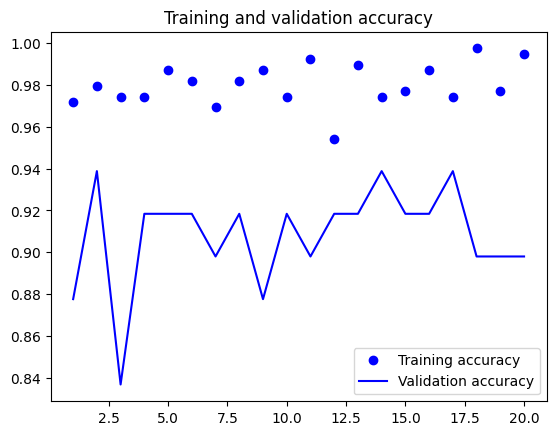

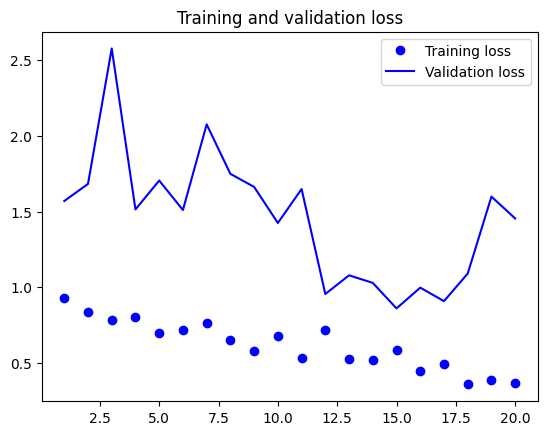

In [66]:
# Generating Visualisation of the Passes
# Allows assessment of training 

# Poor accuracy or high loss could indicate a need to adjust the layers, parameters or review the data samples

import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [67]:
# Finding the accuracy of the current model

test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

2/2 [==============================] - 2s 109ms/step - loss: 1.3921 - accuracy: 0.8776
Test accuracy: 0.878


# Section 4: Final Interations and Fine Tuning


*   Un-Freezing Layers
*   Freezing Last Four Layers



In [68]:
# Setting to true unfreezes all the previous frozen layers
# Removes the last four layers from being trainable
# Allows training for general features without removing all progress so far

conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [69]:
# Building a summary of the current model
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [70]:
# Compiling the final model before running the fitting process
# Can adjust the custom learning rate to fine tweak model
# Can adjust the epochs to fine tune the model

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss"
    ),
    EarlyStopping(
        monitor="val_loss",
        patience=5,  # Number of epochs with no improvement after which training will be stopped
        restore_best_weights=True
    )
]

# Can Adjust epochs To Refine Model
# 20 Chosen as visualisation graph levels out at around pass 15
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)



Epoch 1/30
13/13 [==============================] - 24s 722ms/step - loss: 0.4452 - accuracy: 0.9872 - val_loss: 1.0746 - val_accuracy: 0.9184
Epoch 2/30
13/13 [==============================] - 16s 539ms/step - loss: 0.4216 - accuracy: 0.9949 - val_loss: 1.1281 - val_accuracy: 0.9184
Epoch 3/30
13/13 [==============================] - 16s 450ms/step - loss: 0.4100 - accuracy: 0.9974 - val_loss: 1.2079 - val_accuracy: 0.8980
Epoch 4/30
13/13 [==============================] - 16s 469ms/step - loss: 0.4122 - accuracy: 0.9974 - val_loss: 1.0721 - val_accuracy: 0.9184
Epoch 5/30
13/13 [==============================] - 15s 441ms/step - loss: 0.4053 - accuracy: 1.0000 - val_loss: 1.1363 - val_accuracy: 0.9184
Epoch 6/30
13/13 [==============================] - 16s 490ms/step - loss: 0.4021 - accuracy: 1.0000 - val_loss: 1.3297 - val_accuracy: 0.8980
Epoch 7/30
13/13 [==============================] - 16s 501ms/step - loss: 0.4069 - accuracy: 0.9974 - val_loss: 1.3390 - val_accuracy: 0.9184

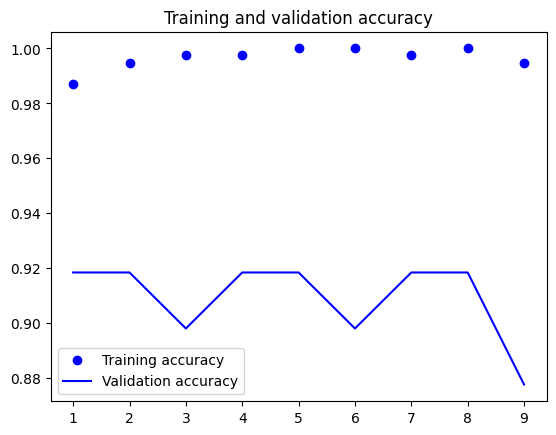

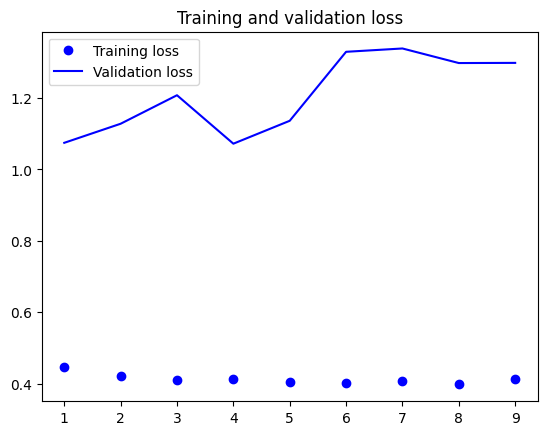

In [71]:
# Generating Visualisation of the Passes
# Allows assessment of training 

# Poor accuracy or high loss could indicate a need to adjust the layers, parameters or review the data samples
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [72]:
# Final accuracy assessment fo total model

model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

2/2 [==============================] - 3s 109ms/step - loss: 1.3835 - accuracy: 0.8776
Test accuracy: 0.878


# Section 5: Downloading the Data Set

In [ ]:
# Comment Out When Not Using

#from google.colab import drive
#from google.colab import files

#model.save('/content/model.h5')

#feature_extraction = '/content/feature_extraction.keras'
#feature_extraction_with_data_aug = '/content/feature_extraction_with_data_augmentation.keras'
#fine_tuning = '/content/fine_tuning.keras'

#files.download(feature_extraction)
#files.download(feature_extraction_with_data_aug)
#files.download(fine_tuning)
#files.download('/content/model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>